In [14]:
import pandas as pd
import seaborn as sns

from s2_analytics import sqlite_import

con, cur = sqlite_import.import_games(logs_dir="logs_ranked/",
                                      sqlite_path="/tmp/s2_ranked.sql",
                                      period_days=40)

# calculate counts if kills for each date and weapon including rows with 0 values
cur.execute("""
create table map_picks_by_date as
    select distinct comb.date,
                comb.mapName,
                sum(iif(r.game is null, 0, 1)) rounds_played -- count only if not null
                -- all date+map combinations
    from (select *
      from (select distinct dates.date from round dates)
               cross join (select distinct mapName from round maps)) comb
         left outer join round r on r.date = comb.date and r.mapName = comb.mapName
    group by comb.date, comb.mapName
""")

## Data summary

In [15]:
query = """
select
    datetime(min(id)/1000, 'unixepoch') first_game_start_time,
    datetime(max(id)/1000, 'unixepoch') last_game_start_time,
    count(1) games_count
from game
"""
pd.read_sql_query(query, con)

,first_game_start_time,last_game_start_time,games_count
0,2022-12-02 20:03:24,2023-01-09 23:44:52,407


In [16]:
query = """
select
    playlistCode,
    count(1) games_count
from game group by playlistCode
"""
pd.read_sql_query(query, con)

,playlistCode,games_count
0,CTF-Standard-4,20
1,CTF-Standard-6,386
2,CTF-Standard-8,1


# Weapon usage trends

/tmp/ipykernel_115737/2768806294.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.set_xticklabels(plt.get_xticklabels(), rotation=90)


<AxesSubplot: title={'center': "14-days rolling average of map picks percentage (mapName < 'ctf_h')"}, xlabel='date', ylabel='pick_percentage_rolling_average_14days'>

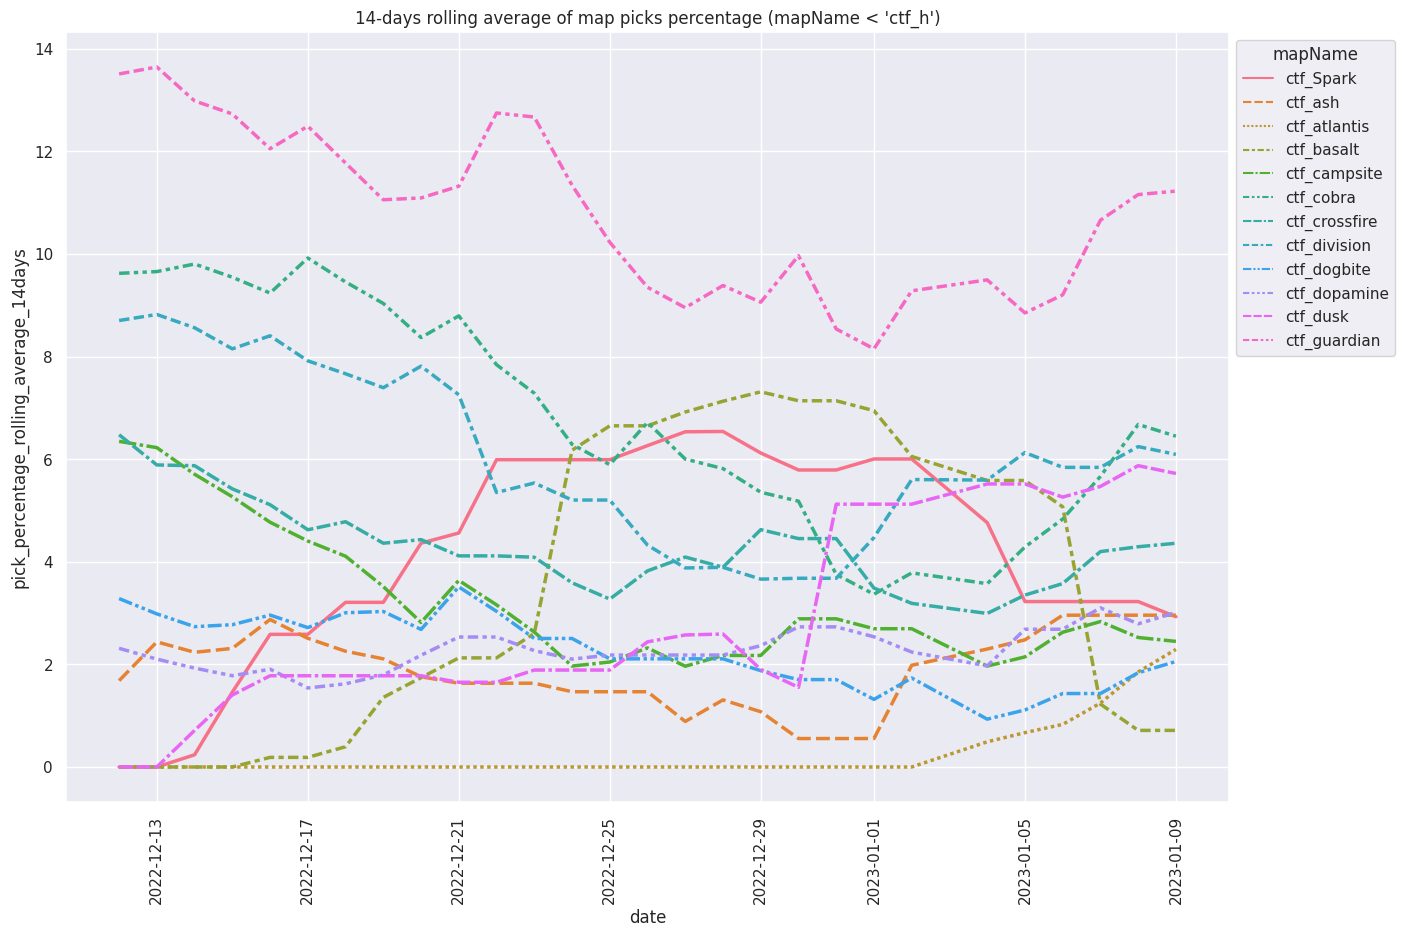

In [17]:

def rolling_average_map_pick(condition, days, height=10):
    result9 = pd.read_sql_query(f"""
    select
        mapName,
        date,
        100.0 * rounds_played / (select sum(rounds_played) from map_picks_by_date mpd2 where mpd.date = mpd2.date) as pick_percentage
    from map_picks_by_date mpd where {condition}
    """, con)
    result9['date'] = pd.to_datetime(result9['date'])

    def generate_rolling_average_plot(df, days):
        groupby = result9.groupby("mapName", as_index=False, group_keys=False)
        df[f"pick_percentage_rolling_average_{days}days"] = groupby.apply(
            lambda grp, freq: grp.rolling(freq, on='date', min_periods=int(0.75 * days))['pick_percentage'].mean(), f"{days}D")
        sns.set(rc={'figure.figsize': (15, height)})
        plt = sns.lineplot(df, x="date", y=f"pick_percentage_rolling_average_{days}days", style="mapName",
                           hue="mapName", linewidth=2.5)
        plt.set_xticklabels(plt.get_xticklabels(), rotation=90)
        plt.set_title(f"{days}-days rolling average of map picks percentage ({condition})")
        sns.move_legend(plt, "upper left", bbox_to_anchor=(1, 1))
        return plt, df

    return generate_rolling_average_plot(result9, days)

rolling_average_map_pick("mapName < 'ctf_h'", 14)[0]

/tmp/ipykernel_115737/2768806294.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.set_xticklabels(plt.get_xticklabels(), rotation=90)


<AxesSubplot: title={'center': "14-days rolling average of map picks percentage (mapName >= 'ctf_h')"}, xlabel='date', ylabel='pick_percentage_rolling_average_14days'>

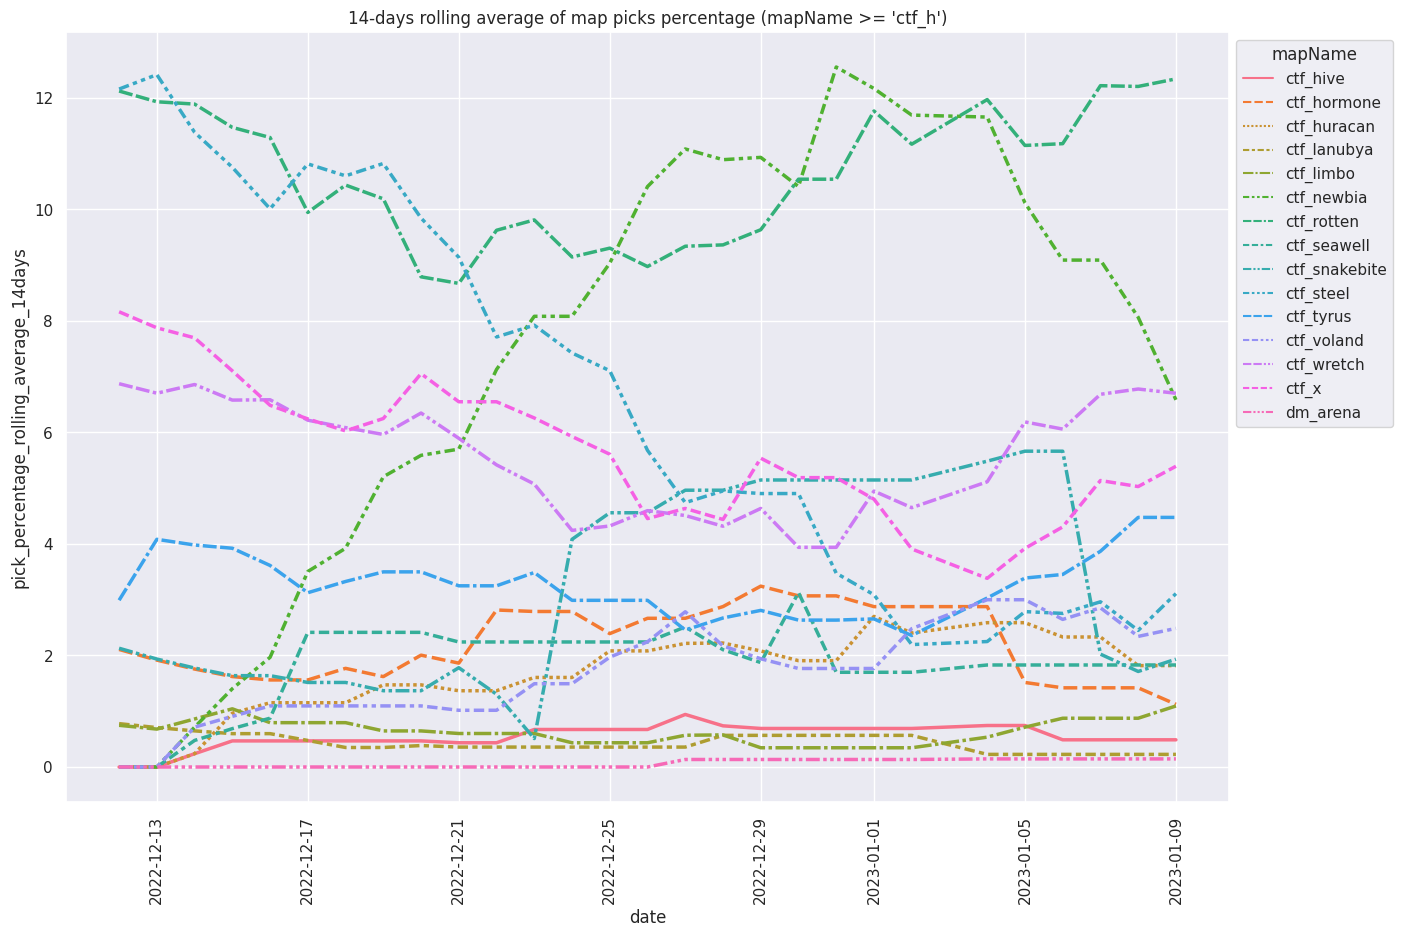

In [18]:
plt, _ = rolling_average_map_pick("mapName >= 'ctf_h'", 14)
plt

# yeah apparently someone managed to play ctf on dm_arena in game 1672178428906

# Sample data for verification

/tmp/ipykernel_115737/2768806294.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.set_xticklabels(plt.get_xticklabels(), rotation=90)


,mapName,date,pick_percentage,pick_percentage_rolling_average_2days
64,ctf_dusk,2023-01-05,0.000000,0.000000
65,ctf_steel,2023-01-05,6.976744,7.743691
66,ctf_dusk,2023-01-06,0.000000,0.000000
67,ctf_steel,2023-01-06,6.250000,6.613372
68,ctf_dusk,2023-01-07,2.702703,1.351351
69,ctf_steel,2023-01-07,2.702703,4.476351
70,ctf_dusk,2023-01-08,5.263158,3.982930
71,ctf_steel,2023-01-08,0.000000,1.351351
72,ctf_dusk,2023-01-09,5.714286,5.488722
73,ctf_steel,2023-01-09,8.571429,4.285714


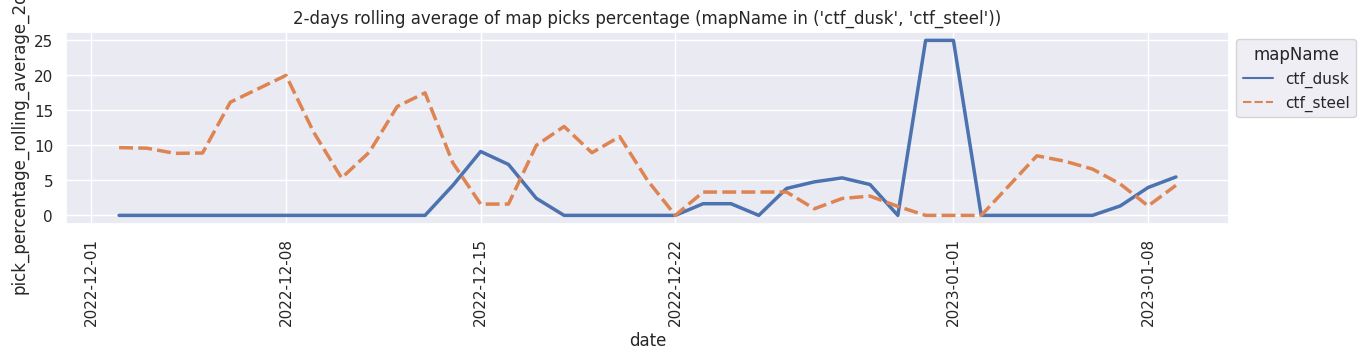

In [21]:
plt, data = rolling_average_map_pick(condition="mapName in ('ctf_dusk', 'ctf_steel')", days=2, height=2.5)
data.sort_values(by=['date', 'mapName'], ascending=True)\
    .tail(n=10)